In [1]:
# 1. Import necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math

In [2]:
# configurations
TRAIN_DATA_DIR = 'train/'
VALIDATION_DATA_DIR = 'val/'
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [3]:
# 2. Load and augment the data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=True,
                                                   seed=1234,
                                                   class_mode='categorical')
val_generator = val_datagen.flow_from_directory(VALIDATION_DATA_DIR,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=False,
                                                   class_mode='categorical')

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [5]:
# 2. Define the model

def model_maker():
    base_model = MobileNet(include_top=False,
                          input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable=False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

model = model_maker()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 3,294,594
Trainable params: 65,730
Non-trainable params: 3,228,864
_______________________________________

In [6]:
# 3. Train the model
model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(0.001),
             metrics=['acc'])
model.fit(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE),
    epochs=10,
    validation_data=val_generator,
    validation_steps=math.ceil(float(VALIDATION_SAMPLES)/BATCH_SIZE))

Epoch 1/10
8/8 [==============================] - 19s 2s/step - loss: 0.5874 - acc: 0.7480 - val_loss: 0.0493 - val_acc: 0.9840
Epoch 2/10
8/8 [==============================] - 18s 2s/step - loss: 0.1344 - acc: 0.9520 - val_loss: 0.0464 - val_acc: 0.9820
Epoch 3/10
8/8 [==============================] - 18s 2s/step - loss: 0.0894 - acc: 0.9720 - val_loss: 0.0251 - val_acc: 0.9920
Epoch 4/10
8/8 [==============================] - 18s 2s/step - loss: 0.0697 - acc: 0.9780 - val_loss: 0.0250 - val_acc: 0.9900
Epoch 5/10
8/8 [==============================] - 18s 2s/step - loss: 0.0630 - acc: 0.9800 - val_loss: 0.0238 - val_acc: 0.9920
Epoch 6/10
8/8 [==============================] - 18s 2s/step - loss: 0.0635 - acc: 0.9760 - val_loss: 0.0253 - val_acc: 0.9920
Epoch 7/10
8/8 [==============================] - 18s 2s/step - loss: 0.0534 - acc: 0.9800 - val_loss: 0.0228 - val_acc: 0.9920
Epoch 8/10
8/8 [==============================] - 18s 2s/step - loss: 0.0743 - acc: 0.9780 - val_loss: 0

In [7]:
# 4. Save the model
model.save('model.h5')

In [8]:
# 5. Model Prediction
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
model = load_model('model.h5')

def image_prediction(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = expanded_img_array/255.
    prediction = model.predict(preprocessed_img)
    print(prediction)

image_prediction('glacier_1.jpg')
image_prediction('glacier_2.jpg')
image_prediction('forest_1.jpg')
image_prediction('forest_2.jpg')
print(val_generator.class_indices)

[[9.663082e-04 9.990337e-01]]
[[3.7439382e-05 9.9996257e-01]]
[[0.99835867 0.00164135]]
[[0.99473816 0.00526181]]
{'forest': 0, 'glacier': 1}


## Analyzing the Results

In [9]:
# File names
filenames = val_generator.filenames
print(len(filenames))
print(filenames[:10])

500
['forest/forest_20056.jpg', 'forest/forest_20062.jpg', 'forest/forest_20082.jpg', 'forest/forest_20089.jpg', 'forest/forest_20091.jpg', 'forest/forest_20095.jpg', 'forest/forest_20098.jpg', 'forest/forest_20100.jpg', 'forest/forest_20108.jpg', 'forest/forest_20117.jpg']


In [10]:
# Check with ground truth values
ground_truth = val_generator.classes
print(ground_truth[:10])
print(len(ground_truth))

[0 0 0 0 0 0 0 0 0 0]
500


In [11]:
# Reverse mapping from class index to class label
label_to_index = val_generator.class_indices
index_to_label = dict((v, k) for k, v in label_to_index.items())
print(index_to_label)

{0: 'forest', 1: 'glacier'}


In [12]:
# Predictions over validation dataset
predictions = model.predict(val_generator)

In [13]:
print(predictions[:10])

[[9.9975783e-01 2.4217441e-04]
 [9.9994600e-01 5.3950131e-05]
 [9.9989080e-01 1.0914787e-04]
 [9.9968028e-01 3.1976099e-04]
 [9.9993157e-01 6.8379748e-05]
 [8.9702594e-01 1.0297407e-01]
 [9.9462259e-01 5.3773681e-03]
 [9.9996042e-01 3.9564871e-05]
 [9.9993205e-01 6.7979061e-05]
 [9.9992144e-01 7.8517216e-05]]


In [14]:
# Getting highest probability from each prediction
prediction_index = []
for prediction in predictions:
    prediction_index.append(np.argmax(prediction))

In [15]:
# Accuracy of predicted values...
def accuracy(predictions, ground_truth):
    total = 0
    for i, j in zip(predictions, ground_truth):
        if i == j:
            total += 1
    return total * 1.0 / len(predictions)

print(accuracy(prediction_index, ground_truth))

0.996


In [16]:
# dict: image index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability, 
                               index_of_highest_probability,ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)

#### Helper function to find the images with highest/lowest probability values

In [17]:
def get_images_with_sorted_probabilities(prediction_table,get_highest_probability,
                                         label,number_of_items,only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

#### Helper function to plot the images for a given query

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message): 
    similar_image_paths = [] 
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value 
        similar_image_paths.append(VALIDATION_DATA_DIR + filenames[name]) 
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

In /Users/krishnakankipati/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/krishnakankipati/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/krishnakankipati/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/krishnakankipati/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


### Most confident predictions of glaciers

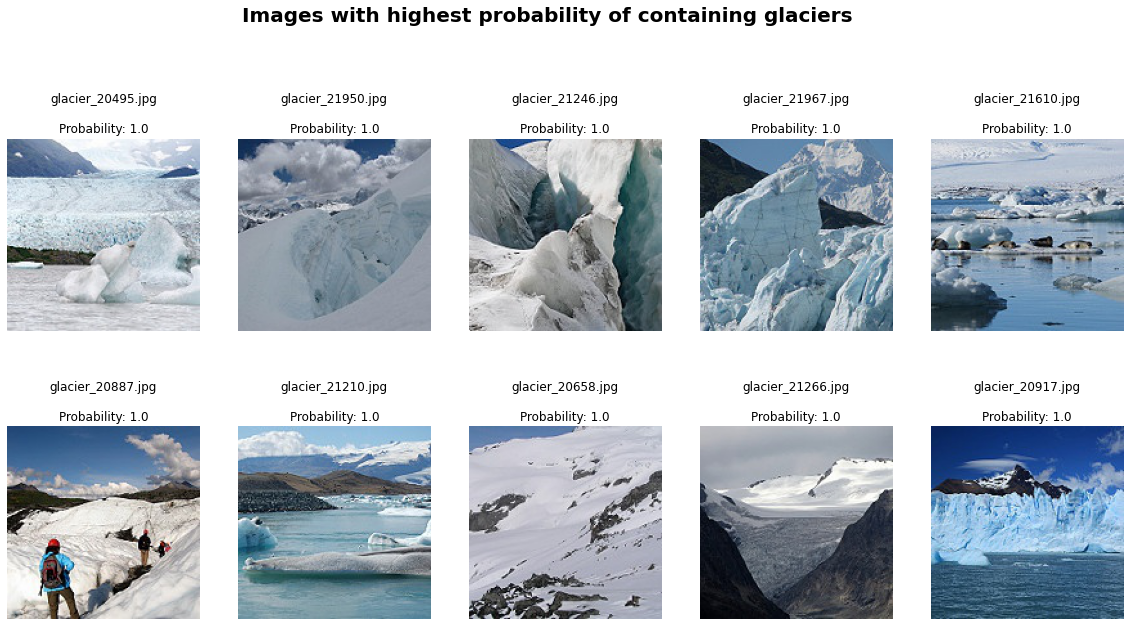

In [19]:
most_confident_glacier_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10,
                                               False)
message = 'Images with highest probability of containing glaciers'
display(most_confident_glacier_images, message)

### Least confident predictions of glaciers

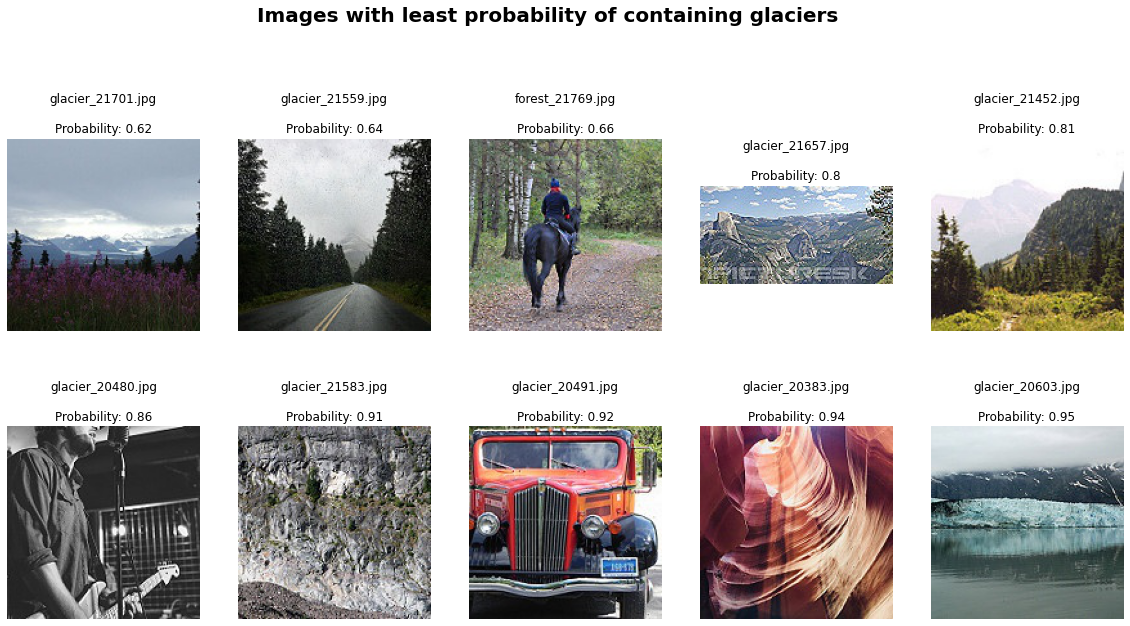

In [20]:
least_confident_glacier_images = get_images_with_sorted_probabilities(prediction_table, False, 1, 10,
                                               False)
message = 'Images with least probability of containing glaciers'
display(least_confident_glacier_images, message)

### Incorrect predictions of glaciers

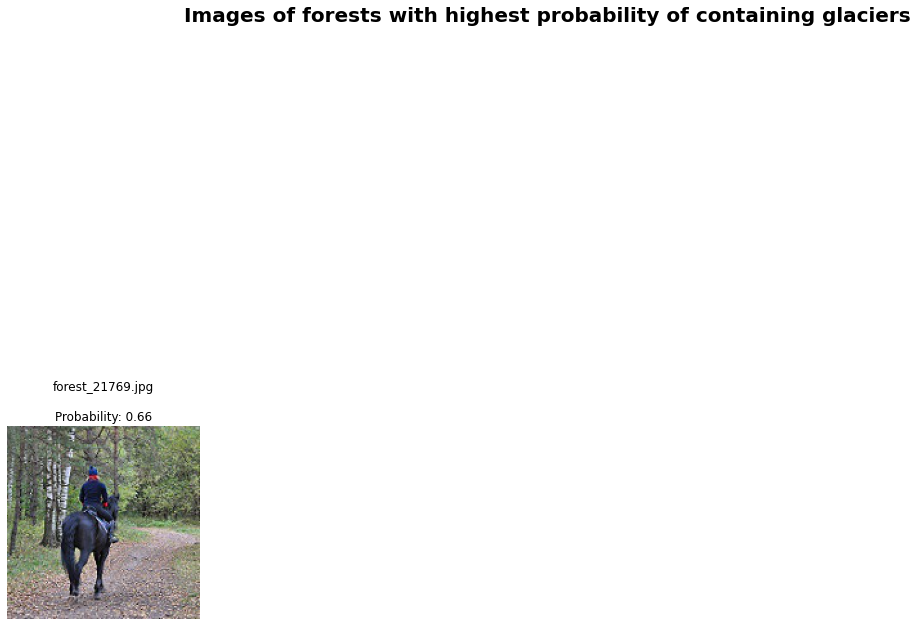

In [21]:
incorrect_glacier_images = get_images_with_sorted_probabilities(prediction_table, True, 1, 10,
                                               True)
message = 'Images of forests with highest probability of containing glaciers'
display(incorrect_glacier_images, message)

### Most confident predictions of forest

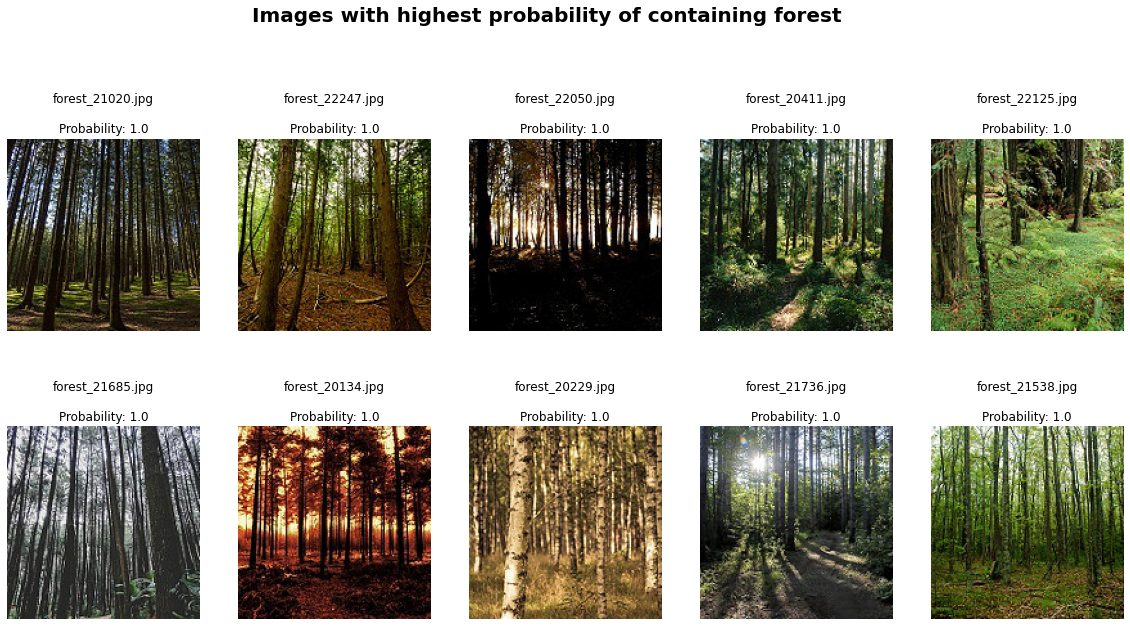

In [22]:
most_confident_forest_images = get_images_with_sorted_probabilities(prediction_table, True, 0, 10,
                                               False)
message = 'Images with highest probability of containing forest'
display(most_confident_forest_images, message)

### Least confident predictions of forest images

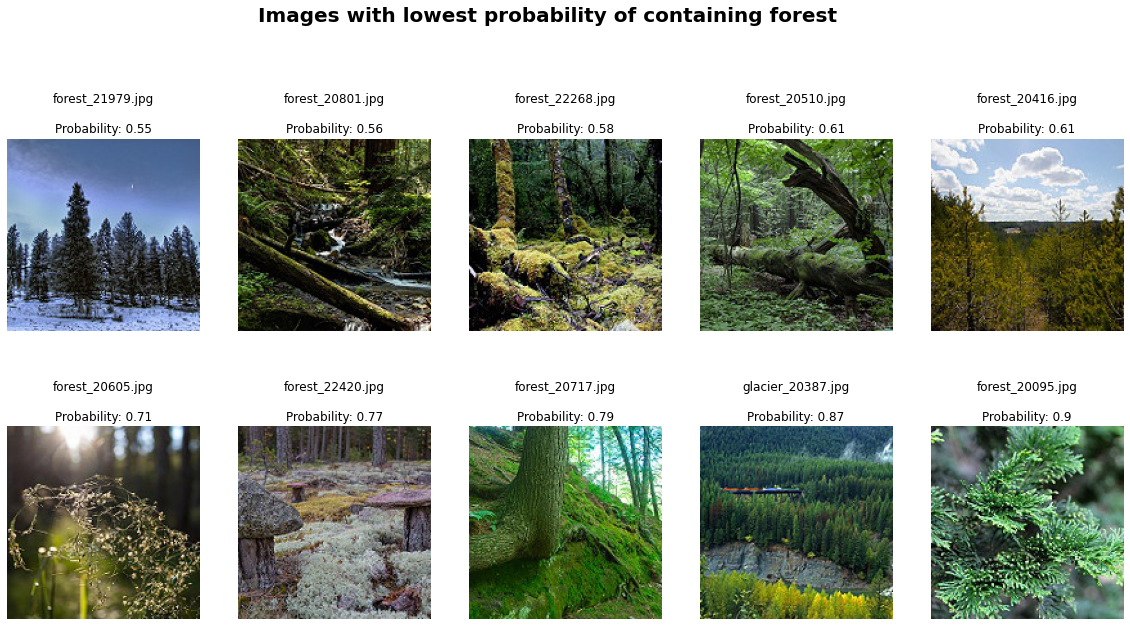

In [23]:
least_confident_forest_images = get_images_with_sorted_probabilities(prediction_table, False, 0, 10,
                                               False)
message = 'Images with lowest probability of containing forest'
display(least_confident_forest_images, message)

### Incorrect predictions of forest

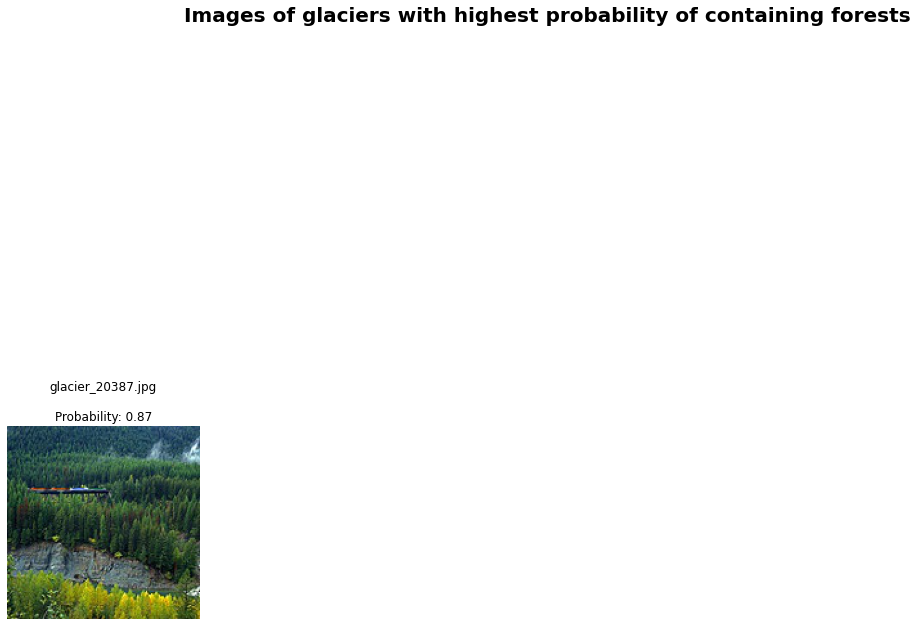

In [24]:
incorrect_forest_images = get_images_with_sorted_probabilities(prediction_table, True, 0, 10,
                                               True)
message = 'Images of glaciers with highest probability of containing forests'
display(incorrect_forest_images, message)